In [122]:
import pandas as pd
import numpy as np
# ploteo
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
# métricas
import psutil
import time
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

## Dataset
- Fuente: [Language Identification, Luca Papariello - Hugging Face](https://huggingface.co/datasets/papluca/language-identification)

In [123]:
splits = {'train': 'train.csv', 'validation': 'valid.csv', 'test': 'test.csv'}
df = pd.read_csv("hf://datasets/papluca/language-identification/" + splits["test"])

df.head()

,labels,text
0,nl,Een man zingt en speelt gitaar.
1,nl,De technologisch geplaatste Nasdaq Composite I...
2,es,Es muy resistente la parte trasera rígida y lo...
3,it,"""In tanti modi diversi, l'abilità artistica de..."
4,ar,منحدر يواجه العديد من النقاشات المتجهه إزاء ال...


In [129]:
# mismo orden q en notebook Massive para mantender coherencia de colores en los plots
common_langs = ['pl', 'it', 'es', 'fr', 'en', 'tr', 'pt', 'de', 'nl']

df = df[df['labels'].isin(common_langs)]

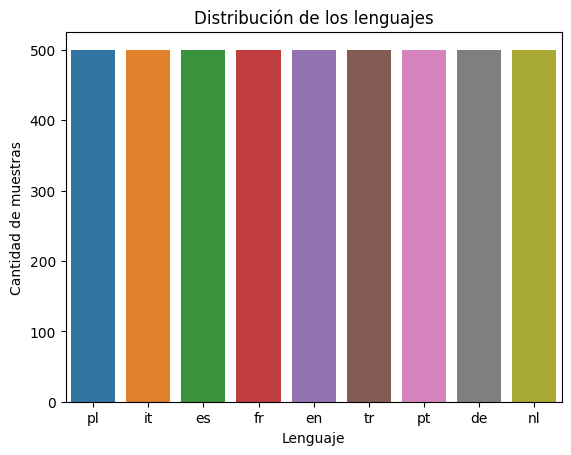

In [130]:
# plot lang distribution
sns.countplot(data=df, x='labels', order=common_langs)
plt.title("Distribución de los lenguajes")
plt.xlabel("Lenguaje")
plt.ylabel("Cantidad de muestras")
plt.savefig('lang_dist.png')
plt.show()

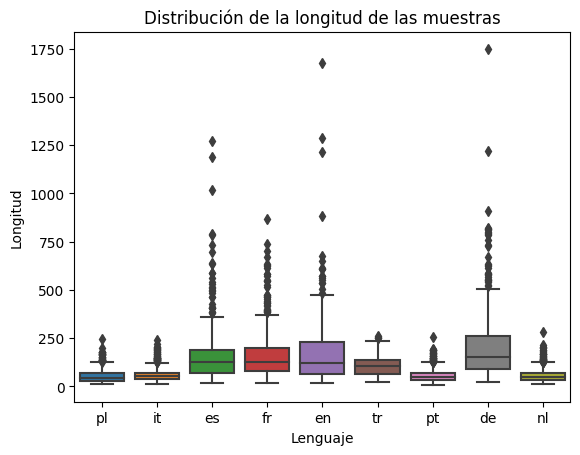

In [131]:
# plot length of sentences by language
df['length'] = df['text'].apply(len)
sns.boxplot(data=df, x='labels', y='length', order=common_langs)
plt.title("Distribución de la longitud de las muestras")
plt.xlabel("Lenguaje")
plt.ylabel("Longitud")
plt.savefig('len_dist.png')
plt.show()

In [13]:
# longitud media por idioma
df.groupby('labels')['length'].mean()

labels
de    203.290
en    170.036
es    156.158
fr    162.560
it     63.198
nl     59.546
pl     56.238
pt     60.724
tr    105.978
Name: length, dtype: float64

In [14]:
# crear k datastes df0 ... dfk-1 con seqs truncadas hasta i con 0 < i < k
k = 100
dfs = {}
for i in range(k):
    dfs[i] = df.copy()
    dfs[i]['seq'] = dfs[i]['text'].apply(lambda x: x[:i+1])

dfs[0].head()

,labels,text,length,seq
0,nl,Een man zingt en speelt gitaar.,31,E
1,nl,De technologisch geplaatste Nasdaq Composite I...,112,D
2,es,Es muy resistente la parte trasera rígida y lo...,108,E
3,it,"""In tanti modi diversi, l'abilità artistica de...",154,""""
6,tr,"Sözlüğün yanı sıra, ortalama modern okuyucu iç...",161,S


## Evaluación

In [15]:
model_names = ['langid', 'langid3', 'fasttext_large', 'fasttext_small', 'fasttext_retrained', 'bi_lstm', 'xlm-roberta']
metric_names = ['time', 'cpu_usage', 'ram_usage']

preds = {}
metrics = {}

for model_name in model_names:
    preds[model_name] = np.full((k, len(df)), '', dtype='<U2')
    metrics[model_name] = {}
    for metric_name in metric_names:
        metrics[model_name][metric_name] = np.zeros(k)

### 1. langid.py
Lui & Baldwin, 2012
- Paper: [langid.py: An Off-the-shelf Language Identification Tool](https://aclanthology.org/P12-3005.pdf)
- Código: [GitHub](https://github.com/saffsd/langid.py)

In [16]:
import langid

langid.set_languages(common_langs)

model_name = 'langid'

for i in tqdm(range(k)):
    time_start = time.time()
    cpu_start = psutil.cpu_percent(interval=None)
    ram_start = psutil.virtual_memory().percent
    
    seqs = dfs[i]['seq'].tolist()
    #
    preds[model_name][i] = [langid.classify(seq)[0] for seq in seqs]
    
    metrics[model_name]['cpu_usage'][i] = (psutil.cpu_percent(interval=None) + cpu_start) / 2
    metrics[model_name]['ram_usage'][i] = (psutil.virtual_memory().percent + ram_start) / 2
    metrics[model_name]['time'][i] = time.time() - time_start

# https://github.com/adbar/py3langid
!pip install py3langid
import py3langid as langid3

langid3.set_languages(common_langs)

model_name = 'langid3'

for i in tqdm(range(k)):
    time_start = time.time()
    cpu_start = psutil.cpu_percent(interval=None)
    ram_start = psutil.virtual_memory().percent
    
    seqs = dfs[i]['seq'].tolist()
    #
    preds[model_name][i] = [langid3.classify(seq)[0] for seq in seqs]
    
    metrics[model_name]['cpu_usage'][i] = (psutil.cpu_percent(interval=None) + cpu_start) / 2
    metrics[model_name]['ram_usage'][i] = (psutil.virtual_memory().percent + ram_start) / 2
    metrics[model_name]['time'][i] = time.time() - time_start

100%|██████████| 100/100 [02:18<00:00,  1.38s/it]


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 746.1/746.1 kB 20.4 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 63.2 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
apache-beam 2.46.0 requires cloudpickle~=2.2.1, but you have cloudpickle 3.0.0 which is incompatible.
apache-beam 2.46.0 requires dill<0.3.2,>=0.3.1.1, but you have dill 0.3.8 which is incompatible.
apache-beam 2.46.0 requires numpy<1.25.0,>=1.14.3, but you have numpy 2.1.3 which is incompatible.
apache-beam 2.46.0 requires pyarrow<10.0.0,>=3.0.0, but you have pyarrow 17.0.0 which is incompatible.
catboost 1.2.7 re

100%|██████████| 100/100 [00:32<00:00,  3.10it/s]


### 2. FastText
Joulin et al., 2017
- Paper: [Enriching Word Vectors with Subword Information](https://arxiv.org/pdf/1607.04606)
- Tutorial: [Language identification in python using fastText](https://medium.com/@c.chaitanya/language-identification-in-python-using-fasttext-60359dc30ed0)
- Documentación: [Fast and accurate language identification using fastText](https://fasttext.cc/blog/2017/10/02/blog-post.html)

In [17]:
import fasttext
!pip install wget
import wget
import os

ws = {
    'fasttext_large': 'https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.bin',
    'fasttext_small': 'https://dl.fbaipublicfiles.com/fasttext/supervised-models/lid.176.ftz',
}

for model_name, url in ws.items():
    # Cargar modelo
    w_path = url.split('/')[-1]
    filename = f"/kaggle/working/{w_path}"
    if os.path.exists(filename):
        os.remove(filename)
    wget.download(url, w_path)
    model = fasttext.load_model(filename)
    
    for i in tqdm(range(k)):
        time_start = time.time()
        cpu_start = psutil.cpu_percent(interval=None)
        ram_start = psutil.virtual_memory().percent
        
        seqs = dfs[i]['seq'].tolist()
        #
        preds[model_name][i] = [model.predict(seq)[0][0][-2:] for seq in seqs]
        
        metrics[model_name]['cpu_usage'][i] = (psutil.cpu_percent(interval=None) + cpu_start) / 2
        metrics[model_name]['ram_usage'][i] = (psutil.virtual_memory().percent + ram_start) / 2
        metrics[model_name]['time'][i] = time.time() - time_start

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=0fcc43b1393543100a489ee6aff37a991f075d441c362dc229d1ab0767893205
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


100%|██████████| 100/100 [00:09<00:00, 10.29it/s]


### 3. Bidirectional LSTM
Toftrup et al., 2021
- Paper: [A reproduction of Apple’s bi-directional LSTM models for language identification in short strings](https://aclanthology.org/2021.eacl-srw.6.pdf)
- Código: [GitHub](https://github.com/AU-DIS/LSTM_langid)

In [18]:
!pip install LanguageIdentifier
from LanguageIdentifier import predict

model_name = 'bi_lstm'

for i in tqdm(range(k)):
    time_start = time.time()
    cpu_start = psutil.cpu_percent(interval=None)
    ram_start = psutil.virtual_memory().percent

    seqs = dfs[i]['seq'].tolist()
    preds[model_name][i] = [predict(seq) for seq in seqs]
    
    metrics[model_name]['cpu_usage'][i] = (psutil.cpu_percent(interval=None) + cpu_start) / 2
    metrics[model_name]['ram_usage'][i] = (psutil.virtual_memory().percent + ram_start) / 2
    metrics[model_name]['time'][i] = time.time() - time_start

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 11.7 MB/s eta 0:00:0000:0100:01


/opt/conda/lib/python3.10/site-packages/LanguageIdentifier/LanguageIdentifier.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_information_dict = torch.load(direct

### 4. XML-RoBERTa
Conneau et al. 2020
- Paper: [Unsupervised Cross-lingual Representation Learning at Scale](https://arxiv.org/pdf/1911.02116)
- Código: [Hugging Face](https://huggingface.co/papluca/xlm-roberta-base-language-detection)

In [115]:
from transformers import pipeline
import torch
from torch.utils.data import Dataset, DataLoader

device = 0 if torch.cuda.is_available() else -1
batch_size = 16

class TextDataset(Dataset):
    def __init__(self, sequences):
        self.sequences = sequences

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx]

pipe = pipeline("text-classification", model="papluca/xlm-roberta-base-language-detection", device=device, batch_size=batch_size)

model_name = 'xlm-roberta'

# Entrenar solamente de 50 a 60 porq el resto ya lo tengo
for i in tqdm(range(50, 60)):
    time_start = time.time()
    cpu_start = psutil.cpu_percent(interval=None)
    ram_start = psutil.virtual_memory().percent
    
    seqs = dfs[i]['seq'].tolist()
    dataset = TextDataset(seqs)
    dataloader = DataLoader(dataset, batch_size=batch_size)

    labels = []
    for batch in dataloader:
        result = pipe(batch)
        labels.extend([r['label'] for r in result])

    preds[model_name][i] = labels
    
    metrics[model_name]['cpu_usage'][i] = (psutil.cpu_percent(interval=None) + cpu_start) / 2
    metrics[model_name]['ram_usage'][i] = (psutil.virtual_memory().percent + ram_start) / 2
    metrics[model_name]['time'][i] = time.time() - time_start

/opt/conda/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
100%|██████████| 10/10 [25:01<00:00, 150.15s/it]


In [116]:
import pickle

# Guardar
with open('preds.pkl', 'wb') as f_preds:
    pickle.dump(preds, f_preds)
with open('metrics.pkl', 'wb') as f_metrics:
    pickle.dump(metrics, f_metrics)

# Cargar
#with open('preds.pkl', 'rb') as f_preds:
#    preds = pickle.load(f_preds)
#with open('metrics.pkl', 'rb') as f_metrics:
#    metrics = pickle.load(f_metrics)

In [117]:
# usar mismos nombres q en notebook de Massive
new_names = {
    'langid': 'langid.py',
    'langid3': 'langid3.py',
    'fasttext_large': 'FastText_Large',
    'fasttext_small': 'FastText_Small',
    'bi_lstm': 'LSTM',
    'xlm-roberta': 'XML-RoBERTa'
}

Precisión promedio FastText_Large: 88.72%
Precisión promedio FastText_Small: 86.47%
Precisión promedio langid.py: 84.09%
Precisión promedio LSTM: 92.33%
Precisión promedio XML-RoBERTa: 87.91%
Precisión promedio langid3.py: 84.09%


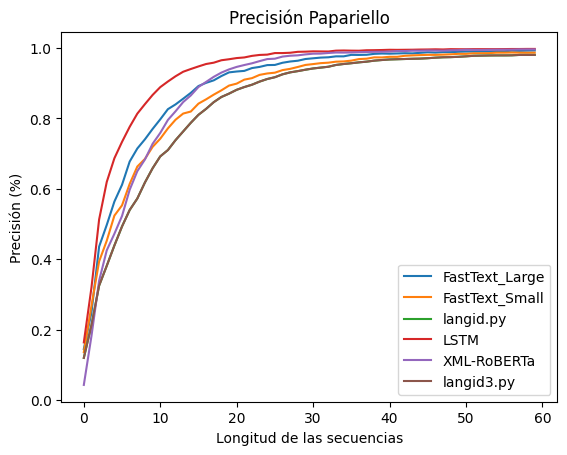

Tiempo promedio de inferencia por ejemplo para FastText_Large: 0.0536 s por ejemplo
Tiempo promedio de inferencia por ejemplo para FastText_Small: 0.0755 s por ejemplo
Tiempo promedio de inferencia por ejemplo para langid.py: 1.3017 s por ejemplo
Tiempo promedio de inferencia por ejemplo para LSTM: 20.1380 s por ejemplo
Tiempo promedio de inferencia por ejemplo para XML-RoBERTa: 97.4232 s por ejemplo
Tiempo promedio de inferencia por ejemplo para langid3.py: 0.3108 s por ejemplo


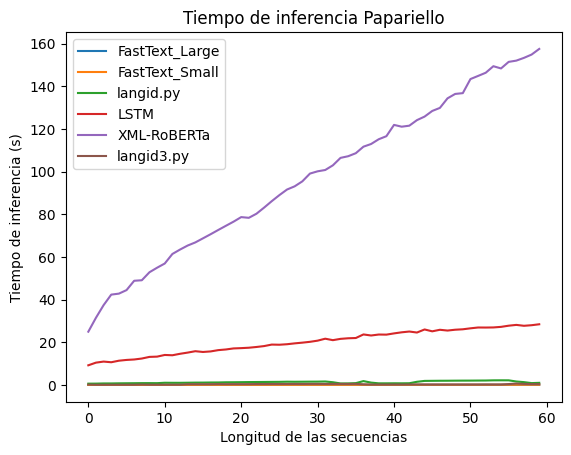

Promedio de uso de RAM fasttext_large: 4.73%
Promedio de uso de RAM fasttext_small: 4.40%
Promedio de uso de RAM langid: 4.37%
Promedio de uso de RAM bi_lstm: 4.58%
Promedio de uso de RAM xlm-roberta: 6.80%
Promedio de uso de RAM langid3: 4.38%


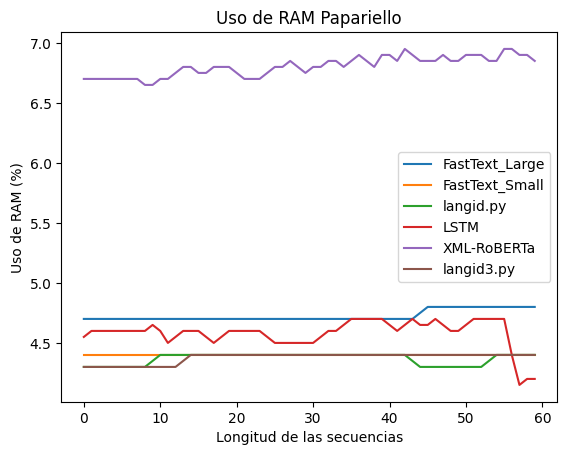

In [133]:
# mismo orden q en notebook Massive para q tengan los mismos colores en los plots
model_names = ['fasttext_large', 'fasttext_small', 'langid', 'bi_lstm', 'xlm-roberta', 'langid3']

def plot(min_i=0, max_i=k):
    # plot acc by i
    for model_name in model_names:
        accs = []
        for i in range(k):
            acc = accuracy_score(dfs[i]['labels'], preds[model_name][i])
            accs.append(acc)
        accs = [acc if acc != 0 else np.nan for acc in accs]  # Replace 0 with np.nan for acc
        plt.plot(range(min_i, max_i), accs[min_i:max_i], label=new_names[model_name])

        # Calculate and print average accuracy
        avg_accuracy = np.nanmean(accs[min_i:max_i]) * 100  # Convert to percentage
        print(f"Precisión promedio {new_names[model_name]}: {avg_accuracy:.2f}%")

    plt.title("Precisión Papariello")
    plt.xlabel("Longitud de las secuencias")
    plt.ylabel("Precisión (%)")
    plt.legend()
    plt.savefig('acc.png')
    plt.show()
    
    # plot inference time by i
    for model_name in model_names:
        inference_times = metrics[model_name]['time']
        inference_times = [time if time != 0 else np.nan for time in inference_times]
        plt.plot(range(min_i, max_i), inference_times[min_i:max_i], label=new_names[model_name])

        avg_inference_time_per_example = np.nanmean(inference_times[min_i:max_i])  # Mean time per example
        print(f"Tiempo promedio de inferencia por ejemplo para {new_names[model_name]}: {avg_inference_time_per_example:.4f} s por ejemplo")

    plt.title("Tiempo de inferencia Papariello")
    plt.xlabel("Longitud de las secuencias")
    plt.ylabel("Tiempo de inferencia (s)")
    #plt.yscale('log')
    plt.legend()
    plt.savefig('inference_time.png')
    plt.show()

    # plot ram usage by i
    for model_name in model_names:
        ram_usage = metrics[model_name]['ram_usage']
        ram_usage = [ram if ram != 0 else np.nan for ram in ram_usage]
        plt.plot(range(min_i, max_i), ram_usage[min_i:max_i], label=new_names[model_name])

        # Calculate and print average RAM usage
        avg_ram_usage = np.nanmean(ram_usage[min_i:max_i])
        print(f"Promedio de uso de RAM {model_name}: {avg_ram_usage:.2f}%")
    
    plt.title("Uso de RAM Papariello")
    plt.xlabel("Longitud de las secuencias")
    plt.ylabel("Uso de RAM (%)")
    plt.legend()
    plt.savefig('ram_usage.png')
    plt.show()

plot(max_i=60)

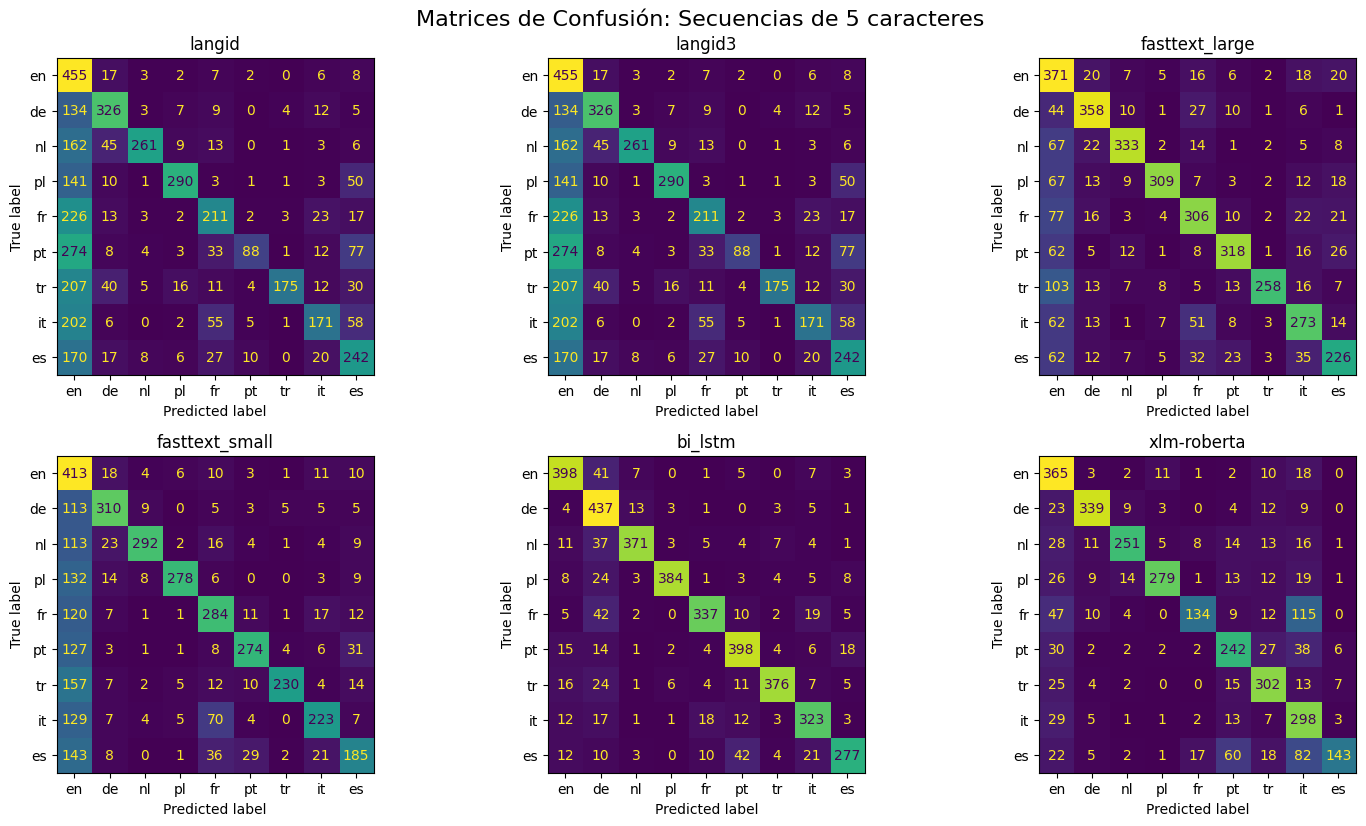

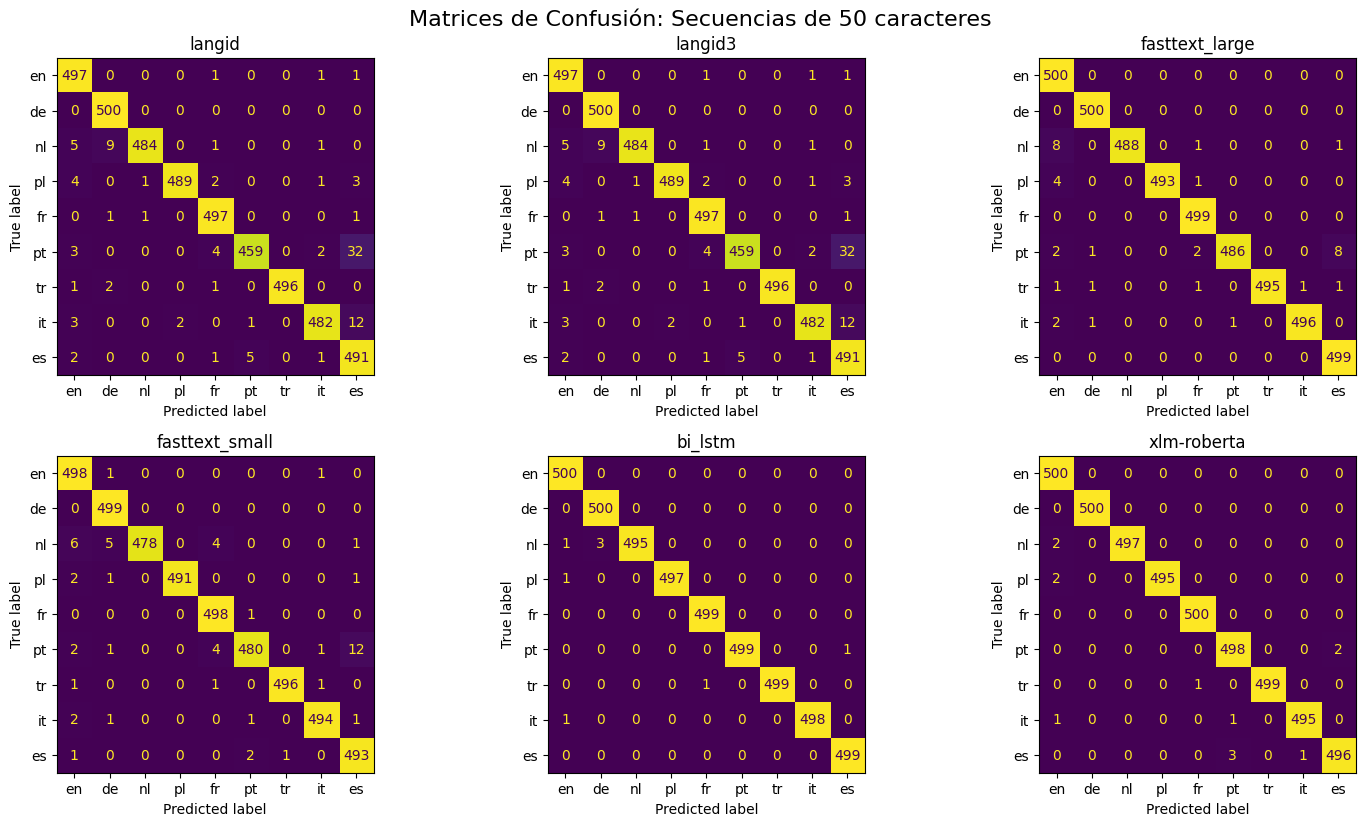

In [102]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrices(seq_len):
    fig, axes = plt.subplots(3, 3, figsize=(15, 12))
    axes = axes.flatten()
    
    for idx, model_name in enumerate(model_names):
        common_lang_mask = dfs[idx]['labels'].isin(common_langs)
        filtered_labels = dfs[idx]['labels'][common_lang_mask]
        filtered_preds = preds[model_name][seq_len][common_lang_mask]
        
        cm = confusion_matrix(filtered_labels, filtered_preds, labels=common_langs)
        
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=common_langs)
        disp.plot(ax=axes[idx], colorbar=False)
        axes[idx].set_title(model_name)
    
    if len(model_names) < len(axes):
        for ax in axes[len(model_names):]:
            fig.delaxes(ax)

    plt.suptitle(f'Matrices de Confusión: Secuencias de {seq_len} caracteres', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'conff_{seq_len}.png')
    plt.show()

plot_confusion_matrices(5)
plot_confusion_matrices(50)